In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from monai.transforms import Compose, LoadImaged, AddChanneld, ToTensord, EnsureChannelFirstd, ResizeD
import pandas as pd
import numpy as np
import random
from pathlib import Path

class AgePredictionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.subjects = df['Subject'].unique()

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        df_subject = self.df[self.df['Subject'] == subject]

        # select a random sample from this subject
        sample = df_subject.sample(n=1, random_state=np.random.randint(0,100))
        
        dir = Path(sample['dir'].values[0])
        img_fa = dir / 'dwmri%fa_brain_MNI152_linear.nii.gz'
        img_md = dir / 'dwmri%md_brain_MNI152_linear.nii.gz'
        dict_sex2numeric = {'female':0, 'male':1}
        sex = torch.tensor(dict_sex2numeric[sample['Sex'].values[0]], dtype=torch.float32)
        age = torch.tensor(sample['Age'].values[0], dtype=torch.float32)

        # Transform
        transform = Compose([
            LoadImaged(keys=['fa', 'md'], image_only=True),
            EnsureChannelFirstd(keys=['fa', 'md']),
            ResizeD(keys=['fa', 'md'], spatial_size=(128, 128, 128), mode='area'),
            ToTensord(keys=['fa', 'md'])
        ])
        data_dict = {'fa': img_fa, 'md': img_md}
        data_dict = transform(data_dict)
        
        return data_dict['fa'], data_dict['md'], sex, age


In [8]:
df_train = pd.read_csv('./data/train.csv')
dataset = AgePredictionDataset(df_train)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
for fa, md, sex, age in dataloader:
    break
print("fa: {}\nmd: {}\nsex: {}\nage: {}".format(fa.shape, md.shape, sex.shape, age.shape))

fa: torch.Size([8, 1, 64, 64, 64])
md: torch.Size([8, 1, 64, 64, 64])
sex: torch.Size([8])
age: torch.Size([8])


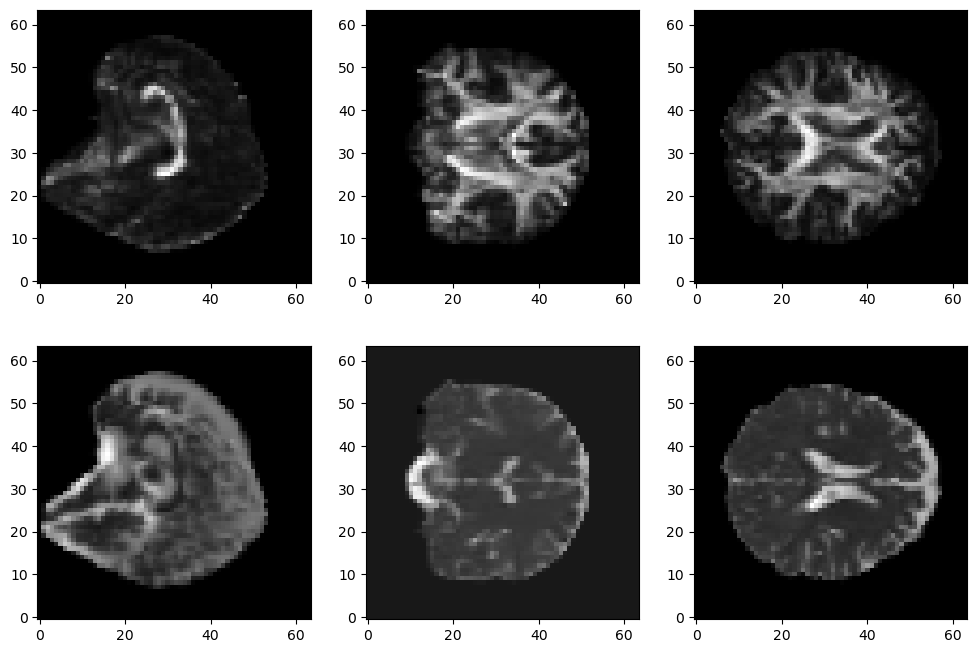

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0,0].imshow(fa[0,0,round(fa.shape[2]/2),:,:], cmap='gray', origin='lower', interpolation='nearest')
axes[0,1].imshow(fa[0,0,:,round(fa.shape[3]/2),:], cmap='gray', origin='lower', interpolation='nearest')
axes[0,2].imshow(fa[0,0,:,:,round(fa.shape[4]/2)], cmap='gray', origin='lower', interpolation='nearest')

axes[1,0].imshow(md[0,0,round(fa.shape[2]/2),:,:], cmap='gray', origin='lower', interpolation='nearest')
axes[1,1].imshow(md[0,0,:,round(fa.shape[3]/2),:], cmap='gray', origin='lower', interpolation='nearest')
axes[1,2].imshow(md[0,0,:,:,round(fa.shape[4]/2)], cmap='gray', origin='lower', interpolation='nearest')